<div class="alert alert-success">
<h1>SETUP</h1>
</div>

## Import libraries

In [21]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline

## Setup input

In [2]:
def setup_input():

    colnames = ['user', 'user_id', 'tweet_id', 'text', 'hashtags',
                'tweet_date', 'user_start', 'followers_count',
                'friends', 'total_tweets', 'location', 'timezone',
                'user_tweet_id', 'sarcasm', 'sarcastic', 'irony',
                'ironic', 'happy', 'sad', 'seriously']
    
    dtypes_file = {'user':str, 'user_id':str, 'tweet_id':str, 'text':str, 'hashtags':str,
                'tweet_date':str, 'user_start':str, 'followers_count':str,
                'friends':str, 'total_tweets':str, 'location':str, 'timezone':str,
                'user_tweet_id':str, 'sarcasm':str, 'sarcastic':str, 'irony':str,
                'ironic':str, 'happy':str, 'sad':str, 'seriously':str}
    
    return colnames, dtypes_file

## Read in raw data

In [3]:
def get_input(path, num_files, hashtags):
    
    get_time('Start time: ')
    
    df = pd.DataFrame()
    num_file = 0
    
    # Set up for getting input
    colnames, dtypes_file = setup_input()

    # Calculate and print total number of folders and files
    _, files = get_num_folders_files(path)

    # iterate through files (containing tweets) in folder:
    for i in next(os.walk(path))[2]:

        if not i.startswith('hashtag'):
            continue

        num_file += 1
        
        if num_file >= num_files:
            break

        print_str = 'Importing file: ' + str(i) + ' (#' + str(num_file) + ' of ' + str(files) + '), time: '
        get_time(print_str)

        fullpath = os.path.join(str(path), str(i))
        
        df_temp = pd.read_csv(filepath_or_buffer = fullpath, sep = '\t',
                                  names=colnames, error_bad_lines=True,
                                  dtype=dtypes_file, encoding='utf-8')
        
        # clean file
        df_temp = clean_file(df_temp, hashtags)

        # if first csv in group, save as df:   
        if num_file == 1:
            df = df_temp
        else:
            df = df.append(df_temp)
                
    get_time('\nDone! End time: ')
    
    return df

## Read in dataframes

In [4]:
def read_in_dfs(df_list, hashtags):
    
    colnames = ['user_tweet_id', 'user', 'user_id', 'tweet_id', 'text', 'hashtags',
                'tweet_date', 'user_start', 'followers_count',
                'friends', 'total_tweets', 'location', 'timezone',
                'sarcasm', 'sarcastic', 'irony', 'ironic', 'happy',
                'sad', 'seriously', 'num_ht']
    
    dtypes_file = {'user_tweet_id':str, 'user':str, 'user_id':str, 'tweet_id':str, 'text':str, 'hashtags':str,
                'tweet_date':str, 'user_start':str, 'followers_count':str,
                'friends':str, 'total_tweets':str, 'location':str, 'timezone':str,
                'sarcasm':str, 'sarcastic':str, 'irony':str, 'ironic':str, 'happy':str,
                'sad':str, 'seriously':str, 'num_ht': str}
    
    dict_dfs = {}

    for i in range(0, len(df_list)):

        key = df_list[i]
        path = './hashtag_dfs/' + df_list[i] + '.txt'
        df = pd.read_csv(filepath_or_buffer = path, sep = '\t',
                         names = colnames, error_bad_lines = True,
                         dtype=dtypes_file, encoding = 'utf-8')
        
        df = clean_file(df, hashtags)
        
        value = df
        dict_dfs[key] = value 
        
        print('Dataframe ' + df_list[i] + ' loaded, length = {:,}.'.format(len(df)))

    return dict_dfs

## Clean file

In [5]:
def clean_file(df, hashtags):
    
    # Remove first row (duplicate with column names)
    df = df.iloc[1:]
    
    # Convert numeric columns to integers:
    pd.to_numeric(df['followers_count'], errors='coerce')
    pd.to_numeric(df['friends'], errors='coerce')
    pd.to_numeric(df['total_tweets'], errors='coerce')
    
    df['followers_count'] = df['followers_count'].astype(int)
    df['friends'] = df['friends'].astype(int)
    df['total_tweets'] = df['total_tweets'].astype(int)
    
    for ht in hashtags:
        pd.to_numeric(df[ht], errors ='coerce')
        df[ht] = df[ht].astype(int)
        
    return df

## Get number of folders and files

In [6]:
def get_num_folders_files(path):
    
    folders = 0
    files = 0

    for _, dirnames, filenames in os.walk(path):
        folders += len(dirnames)
        files += len(filenames)
    
    print('\nThere are {:,} total folders and {:,} total files.'.format(folders, files))
    
    return folders, files

## Get time

In [7]:
import datetime

def get_time(print_string):

    now = datetime.datetime.now()
    hour=int(now.hour)
    minute=int(now.minute)
    second=int(now.second)
    
    if(len(str(abs(minute)))) == 1:
        minute_str = "0" + str(minute)
    else:
        minute_str = str(minute)    
    
    if print_string != "":
        print(print_string + str(hour) + ":" + str(minute_str) + ":" + str(second))
    else:
        return hour, minute_str, second

<div class="alert alert-success">
<h1>DATA CLEANING</h1>
</div>

## Clean data
Drop rows with missing tweet text and report total number of tweets and users

In [8]:
def clean_data(df):
    
    # drop rows with missing tweet text
    df = df[~df.text.isnull()]
    
    # if index hasn't been set already
    if df.index.name == None:
        # remove duplicate tweets
        df = df.drop_duplicates(subset='user_tweet_id', keep = 'first')
        # set index to 'user_tweet_id' column
        df = df.set_index(['user_tweet_id'])
    
    # encode tweet text as utf-8
    col_text = df.columns.get_loc('text')
    for i in range(0,len(df)):
        df.iloc[i,col_text].encode('utf-8')

    return df

## Count total hashtags

In [9]:
def count_total_ht(df):
    
    df['num_ht'] = 0
    df['num_ht'][df['hashtags'] != '[]'] = df.hashtags.str.count(',')+1

    return df

## Count hashtags

In [10]:
def count_ht(df, perform_subset, ht):

    if perform_subset == True:
        
        df = df[df[ht] == 1]
    
    n_tweets = len(df)
    n_users = df.user.unique().size

    print('\nNumber of tweets with {} hashtag: {:,d}'.format(ht, n_tweets))
    print('Number of users with {} hashtag: {:,d}'.format(ht, n_users))

<div class="alert alert-success">
<h1>EXPLORATORY DATA ANALYSIS</h1>
</div>

## Get summary stats by hashtag

In [11]:
def get_stats(df, ht):
    
    df = df.drop_duplicates(subset = 'user', keep = 'first')
    
    print('\nSUMMARY STATS FOR "{}" HASHTAG'.format(ht.upper()))
    
    cols = ['followers_count', 'friends', 'total_tweets']
    
    print('\n\tTotal users: {:,}'.format(df.user.unique().size))
    
    for i in cols:
        
        col = df[i]
    
        print('\n\t{}'.format(i.upper()),
              '\n\tMean: {:,.1f}'.format(np.mean(col)),
              '\n\tSD: {:,.1f}'.format(np.std(col)),
              '\n\tRange: {:,.1f} to {:,.1f}'.format(col.min(), col.max()))

## Calculate number of hashtag uses
Given a dataframe and a hashtag as input, calculate and display the number of users that used the hashtag

In [12]:
def calc_num_ht_uses(df, ht):
    
    # calculate number of tweets each user made
    df_counts = df.groupby('user').sum() 
    
    print("\n\tNumber of users that used '" + str(ht) + "' hashtag X times:")

    for i in range(1,6,1):
        ct = len(df_counts[(df_counts[ht] == i)])
        print('\tX = ' + str(i) + ' time(s): {:,}'.format(ct))

    print("\n\tNumber of users that used '" + str(ht) + "' hashtag more than X times:")

    ct = len(df_counts[(df_counts[ht] > 5)])
    print('\tX > ' + str(5) + ' times: {:,}'.format(ct))

## Make histogram

In [13]:
def make_hist(df, col, num_grps, xlabel, ylabel, title, filename):
    
    # convert column to string
    df[col] = df[col].astype(str)

    # remove missing values
    df = df[df[col] != 'nan']

    df[col].value_counts()[0:num_grps].plot(kind = 'bar')
    plt.xlabel(xlabel)
    plt.xticks(rotation=0)
    plt.ylabel(ylabel)
    plt.title(title + '\n')
    plt.xticks(rotation=90)
    
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]    
    fig_size[0] = 5
    fig_size[1] = 3
    plt.rcParams["figure.figsize"] = fig_size
    
    if filename != '':
        filepath = './graphs/' + filename + '.png'
        plt.savefig(filepath, bbox_inches='tight')

<div class="alert alert-success">
<h1>MAIN CODE</h1>
</div>

In [14]:
input_path = './hashtag_tweets/'

num_files = np.inf
hashtags = ['sarcasm','sarcastic','irony','ironic','happy','sad','seriously']

"""Check whether hashtag dataframes already exist"""
df_list = ['tweets_all', 'tweets_sarcasm', 'tweets_sad', 'tweets_happy', 'tweets_seriously']

for df in df_list:
    filepath = './hashtag_dfs/' + df + '.txt'
    if not os.path.isfile(filepath):        
        dfs_exist = False
    else:
        dfs_exist = True

if dfs_exist == False:
    """if hashtag dataframes DON'T already exist, get input and create them"""
    
    print('Dataframes do not exist, creating now.')
    tweets_all = get_input(input_path, num_files, hashtags)
else:
    """if hashtag dataframes DO already exist, load them"""

    print('Dataframes already exist, loading now.')
    
    dict_dfs = read_in_dfs(df_list, hashtags)
    tweets_all = dict_dfs['tweets_all']    
    tweets_sarcasm = dict_dfs['tweets_sarcasm']    
    tweets_happy = dict_dfs['tweets_happy']    
    tweets_sad = dict_dfs['tweets_sad']    
    tweets_seriously = dict_dfs['tweets_seriously']

Dataframes already exist, loading now.


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

Dataframe tweets_all loaded, length = 95,860.
Dataframe tweets_sarcasm loaded, length = 30,910.
Dataframe tweets_sad loaded, length = 40,861.
Dataframe tweets_happy loaded, length = 12,639.
Dataframe tweets_seriously loaded, length = 11,450.


In [15]:
"""If dataframes do NOT exist, create them and save them as text files"""
if dfs_exist == False:
    
    # subset data to tweets with only one hashtag
    tweets_all = count_total_ht(tweets_all)
    tweets_all = tweets_all[tweets_all.num_ht == 1]
    
    # remove duplicate tweets & drop rows with no tweet text
    tweets_all = clean_data(tweets_all)
    
    # create subset dataframes
    tweets_sarcasm = tweets_all[tweets_all.sarcasm == 1]
    tweets_happy = tweets_all[tweets_all.happy == 1]
    tweets_sad = tweets_all[tweets_all.sad == 1]
    tweets_seriously = tweets_all[tweets_all.seriously == 1]
    
    # only include tweets with hashtag at end 
    pattern = r'\bsarcasm\b$'
    tweets_sarcasm = tweets_sarcasm[(tweets_sarcasm['text'].str.contains(pattern, case=False, na=False, regex=True))]

    pattern = r'\bhappy\b$'
    tweets_happy = tweets_happy[(tweets_happy['text'].str.contains(pattern, case=False, na=False, regex=True))]

    pattern = r'\bsad\b$'
    tweets_sad = tweets_sad[(tweets_sad['text'].str.contains(pattern, case=False, na=False, regex=True))]

    pattern = r'\bseriously\b$'
    tweets_seriously = tweets_seriously[(tweets_seriously['text'].str.contains(pattern, case=False, na=False, regex=True))]
    
    # remove hashtag from tweet text
    tweets_sarcasm['text'] = tweets_sarcasm['text'].str.replace('#sarcasm', '', case=False)
    tweets_happy['text'] = tweets_happy['text'].str.replace('#happy', '', case=False)
    tweets_sad['text'] = tweets_sad['text'].str.replace('#sad', '', case=False)
    tweets_seriously['text'] = tweets_seriously['text'].str.replace('#seriously', '', case=False)
    
    # remove URLs from tweet text
    pattern1 = r'http\S+'
    pattern2 = r'www\S+'
    tweets_sarcasm['text'] = tweets_sarcasm['text'] .str.replace(pattern1, '')
    tweets_sarcasm['text'] = tweets_sarcasm['text'] .str.replace(pattern2, '')
    tweets_happy['text'] = tweets_happy['text'] .str.replace(pattern1, '')
    tweets_happy['text'] = tweets_happy['text'] .str.replace(pattern2, '')
    tweets_sad['text'] = tweets_sad['text'] .str.replace(pattern1, '')
    tweets_sad['text'] = tweets_sad['text'] .str.replace(pattern2, '')
    tweets_seriously['text'] = tweets_seriously['text'] .str.replace(pattern1, '')
    tweets_seriously['text'] = tweets_seriously['text'] .str.replace(pattern2, '')

    # create new dataframe containing all tweets for above hashtags only
    tweets_all = pd.concat([tweets_sarcasm, tweets_happy, tweets_sad, tweets_seriously])
    
    # save dataframes
    filename = 'tweets_all'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_all.to_csv(filepath, sep = '\t', index = True, header = True)

    filename = 'tweets_sarcasm'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_sarcasm.to_csv(filepath, sep = '\t', index = True, header = True)

    filename = 'tweets_happy'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_happy.to_csv(filepath, sep = '\t', index = True, header = True)

    filename = 'tweets_sad'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_sad.to_csv(filepath, sep = '\t', index = True, header = True)

    filename = 'tweets_seriously'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_seriously.to_csv(filepath, sep = '\t', index = True, header = True)

### Count number of tweets and users

In [16]:
count_ht(tweets_sarcasm, False, 'sarcasm')
count_ht(tweets_happy, False, 'happy')
count_ht(tweets_sad, False, 'sad')
count_ht(tweets_seriously, False, 'seriously')


Number of tweets with sarcasm hashtag: 30,910
Number of users with sarcasm hashtag: 23,509

Number of tweets with happy hashtag: 12,639
Number of users with happy hashtag: 10,149

Number of tweets with sad hashtag: 40,861
Number of users with sad hashtag: 26,456

Number of tweets with seriously hashtag: 11,450
Number of users with seriously hashtag: 9,033


### Get stats by hashtag

In [17]:
get_stats(tweets_sarcasm, 'sarcasm')
calc_num_ht_uses(tweets_sarcasm, 'sarcasm')

get_stats(tweets_happy, 'happy')
calc_num_ht_uses(tweets_happy, 'happy')

get_stats(tweets_sad, 'sad')
calc_num_ht_uses(tweets_sad, 'sad')

get_stats(tweets_seriously, 'seriously')
calc_num_ht_uses(tweets_seriously, 'seriously')


SUMMARY STATS FOR "SARCASM" HASHTAG

	Total users: 23,509

	FOLLOWERS_COUNT 
	Mean: 868.2 
	SD: 35,070.6 
	Range: 0.0 to 5,192,273.0

	FRIENDS 
	Mean: 629.2 
	SD: 1,671.0 
	Range: 0.0 to 176,631.0

	TOTAL_TWEETS 
	Mean: 4,295.6 
	SD: 8,341.5 
	Range: 2.0 to 446,022.0

	Number of users that used 'sarcasm' hashtag X times:
	X = 1 time(s): 19,213
	X = 2 time(s): 2,883
	X = 3 time(s): 773
	X = 4 time(s): 289
	X = 5 time(s): 159

	Number of users that used 'sarcasm' hashtag more than X times:
	X > 5 times: 192

SUMMARY STATS FOR "HAPPY" HASHTAG

	Total users: 10,149

	FOLLOWERS_COUNT 
	Mean: 812.5 
	SD: 10,361.0 
	Range: 0.0 to 753,605.0

	FRIENDS 
	Mean: 693.7 
	SD: 2,478.5 
	Range: 0.0 to 223,235.0

	TOTAL_TWEETS 
	Mean: 3,851.3 
	SD: 5,809.7 
	Range: 1.0 to 175,701.0

	Number of users that used 'happy' hashtag X times:
	X = 1 time(s): 8,559
	X = 2 time(s): 1,111
	X = 3 time(s): 287
	X = 4 time(s): 103
	X = 5 time(s): 41

	Number of users that used 'happy' hashtag more than X times:
	X >

### Top user locations by hashtag

In [18]:
print('\nSarcasm Hashtag:\n{}'.format(tweets_sarcasm['location'].value_counts()[0:5]))
print('\nHappy Hashtag:\n{}'.format(tweets_happy['location'].value_counts()[0:5]))
print('\nSad Hashtag:\n{}'.format(tweets_sad['location'].value_counts()[0:5]))
print('\nSeriously Hashtag:\n{}'.format(tweets_seriously['location'].value_counts()[0:5]))


Sarcasm Hashtag:
New York, NY       255
Los Angeles, CA    250
Chicago, IL        245
United States      212
Seattle, WA        172
Name: location, dtype: int64

Happy Hashtag:
Los Angeles, CA    141
New York, NY       132
London             124
Chicago, IL        119
Washington, DC      95
Name: location, dtype: int64

Sad Hashtag:
United States      624
Los Angeles, CA    373
New York, NY       352
Chicago, IL        311
Washington, DC     274
Name: location, dtype: int64

Seriously Hashtag:
Seriously?         171
Chicago, IL        126
Washington, DC     116
New York, NY       113
Los Angeles, CA    112
Name: location, dtype: int64


### Top timezones by hashtag

In [19]:
print('\nSarcasm Hashtag:\n{}'.format(tweets_sarcasm['timezone'].value_counts()[0:5]))
print('\nHappy Hashtag:\n{}'.format(tweets_happy['timezone'].value_counts()[0:5]))
print('\nSad Hashtag:\n{}'.format(tweets_sad['timezone'].value_counts()[0:5]))
print('\nSeriously Hashtag:\n{}'.format(tweets_seriously['timezone'].value_counts()[0:5]))


Sarcasm Hashtag:
Eastern Time (US & Canada)    7334
Central Time (US & Canada)    5323
Pacific Time (US & Canada)    3552
Quito                         1210
London                        1088
Name: timezone, dtype: int64

Happy Hashtag:
Eastern Time (US & Canada)    2631
Central Time (US & Canada)    1964
Pacific Time (US & Canada)    1427
London                         779
Quito                          662
Name: timezone, dtype: int64

Sad Hashtag:
Eastern Time (US & Canada)    8679
Pacific Time (US & Canada)    5107
Central Time (US & Canada)    4978
Quito                         1516
Atlantic Time (Canada)        1229
Name: timezone, dtype: int64

Seriously Hashtag:
Eastern Time (US & Canada)    2809
Central Time (US & Canada)    2329
Pacific Time (US & Canada)    1190
Quito                          678
Atlantic Time (Canada)         475
Name: timezone, dtype: int64


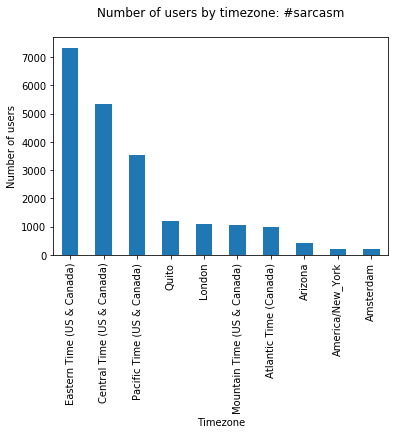

In [22]:
title = 'Number of users by timezone: #sarcasm'
xlabel = 'Timezone'
ylabel = 'Number of users'
filename = 'timezones_sarcasm'
make_hist(tweets_sarcasm, 'timezone', 10, xlabel, ylabel, title, filename)

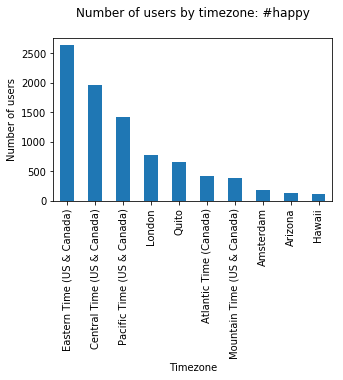

In [23]:
title = 'Number of users by timezone: #happy'
xlabel = 'Timezone'
ylabel = 'Number of users'
filename = 'timezones_happy'
make_hist(tweets_happy, 'timezone', 10, xlabel, ylabel, title, filename)

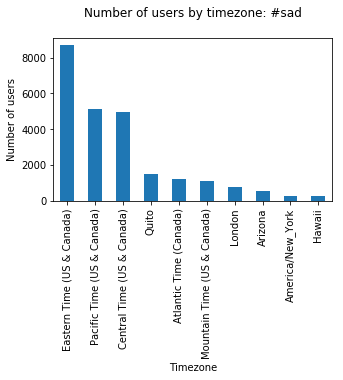

In [24]:
title = 'Number of users by timezone: #sad'
xlabel = 'Timezone'
ylabel = 'Number of users'
filename = 'timezones_sad'
make_hist(tweets_sad, 'timezone', 10, xlabel, ylabel, title, filename)

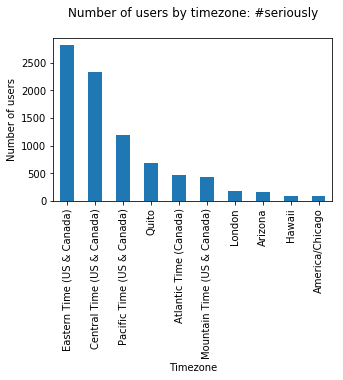

In [25]:
title = 'Number of users by timezone: #seriously'
xlabel = 'Timezone'
ylabel = 'Number of users'
filename = 'timezones_seriously'
make_hist(tweets_seriously, 'timezone', 10, xlabel, ylabel, title, filename)